In [9]:
# ======== imports modules ========

# data table manip
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [10]:
# ======== clean csv files ========

# indicators csv (drops blank first row, gets rid of dt indicator columns, sets index to datetime)
indicators = pd.read_csv('Indicators_train.csv').iloc[1:].dropna(how='all')
indicators.date = pd.to_datetime(indicators.date)
for column in indicators:
    if 'dt' in column:
        del indicators[column]
    elif 'date' in column:
        continue
    else:
        indicators[column] = indicators[column].astype(float)
indicators = indicators.set_index(indicators.date)
del indicators['date']

indicatorstest = pd.read_csv('Indicators_test.csv').iloc[1:].dropna(how='all')
indicatorstest.date = pd.to_datetime(indicatorstest.date)
for column in indicatorstest:
    if 'dt' in column:
        del indicatorstest[column]
    elif 'date' in column:
        continue
    else:
        indicatorstest[column] = indicatorstest[column].astype(float)
indicatorstest = indicatorstest.set_index(indicatorstest.date)
del indicatorstest['date']

frames = [indicators,indicatorstest]
mainindicators = pd.concat(frames)

# stock - csv (sets index to datetime)
stock = pd.read_csv('stocks-us-adjClose.csv')
stock.date = pd.to_datetime(stock.date)
stock = stock.set_index(stock.date)
del stock['date']

# sector - csv (loads csv and prints sectors for reference)
sector = pd.read_csv('Company_information.csv', encoding = "ISO-8859-1")
seclist = sector.Sector.unique()
sectorset = []
for member in seclist:
    if str(member) != 'nan':
        sectorset.append(member)

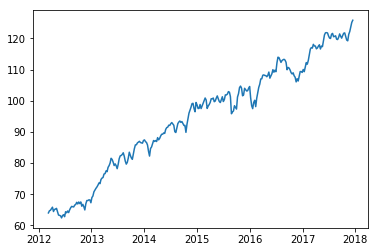

In [11]:
# ======== merge sector and indicators for single dataframe ========

# main sectors - csv
mainsectors = pd.read_csv('sector_ETFs.csv')
mainsectors['Date'] = pd.to_datetime(mainsectors['Date'])
mainsectors = mainsectors.set_index(mainsectors['Date'])
del mainsectors['Date']

mainsectorsplus = pd.read_csv('sector_ETFs-2-corrected.csv')
mainsectorsplus['Date'] = pd.to_datetime(mainsectorsplus['Date'])
mainsectorsplus = mainsectorsplus.set_index(mainsectorsplus['Date'])
del mainsectorsplus['Date']
del mainsectorsplus['Market (^RUA)']

# Merge sectors with indicators

frames = [mainsectors,mainsectorsplus]
mainsectors = pd.concat(frames)

sec_indic = pd.merge(mainsectors,mainindicators, how='inner', left_index=True, right_index=True).dropna(how='any')

# resample dataframe by Friday via mean of the week
sec_indic = sec_indic.resample('W-Fri').mean()

# reindex with future dates
sec_predict = sec_indic.copy()
index = pd.date_range('2012-03-09', '2018-6-29', freq='W-Fri')
sec_indic = sec_indic.reindex(index)

# data appears linear and not logarithmic
plt.plot(sec_indic['Consumer Goods (IYK)'])
plt.show()

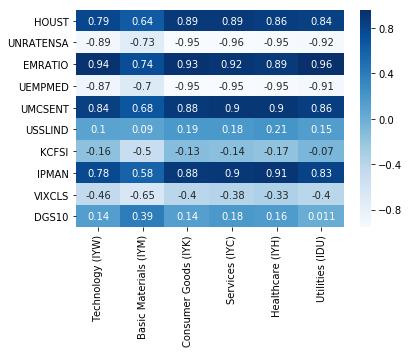

In [12]:
# ======== checks correllations between ticker sectors and macro economic indicators ========

sectors=['Technology (IYW)', 'Basic Materials (IYM)', 'Consumer Goods (IYK)', 'Services (IYC)', 'Healthcare (IYH)', 'Utilities (IDU)']
features=['HOUST', 'UNRATENSA', 'EMRATIO', 'UEMPMED',
       'UMCSENT', 'USSLIND', 'KCFSI', 'IPMAN', 'VIXCLS', 'DGS10']
sec_indic.corr()

# initiate empty dataframe
corr = pd.DataFrame()
for a in features:
    for b in sectors:
        corr.loc[a, b] = sec_indic.corr().loc[a, b]

corr

sns.heatmap(corr,cmap='Blues',annot=True)
plt.show()

# Correlations: Dark blue indicates strong correlation, White indicates strong inverse correlation

,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU),HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
Technology (IYW),1.000000,0.880538,0.940231,0.937417,0.912523,0.955263,0.790077,-0.891763,0.937905,-0.868503,0.844380,0.103296,-0.159397,0.779407,-0.456551,0.139650
Basic Materials (IYM),0.880538,1.000000,0.820422,0.821894,0.812364,0.818506,0.643731,-0.734032,0.744070,-0.700513,0.680149,0.090305,-0.502955,0.582681,-0.654635,0.393230
Consumer Goods (IYK),0.940231,0.820422,1.000000,0.990225,0.971931,0.969870,0.887796,-0.952884,0.934897,-0.950147,0.882892,0.186523,-0.126442,0.884996,-0.396950,0.136870
Services (IYC),0.937417,0.821894,0.990225,1.000000,0.985628,0.943992,0.885453,-0.955981,0.918219,-0.953013,0.901154,0.183848,-0.144112,0.899011,-0.376082,0.184742
Healthcare (IYH),0.912523,0.812364,0.971931,0.985628,1.000000,0.920135,0.860653,-0.946379,0.892281,-0.947616,0.901731,0.214399,-0.170812,0.908833,-0.334680,0.161990
Utilities (IDU),0.955263,0.818506,0.969870,0.943992,0.920135,1.000000,0.841099,-0.919800,0.960842,-0.905668,0.860934,0.147088,-0.070410,0.825266,-0.398811,0.011196
HOUST,0.790077,0.643731,0.887796,0.885453,0.860653,0.841099,1.000000,-0.880294,0.827208,-0.876999,0.797134,0.148687,-0.070361,0.859217,-0.263392,0.095084
UNRATENSA,-0.891763,-0.734032,-0.952884,-0.955981,-0.946379,-0.919800,-0.880294,1.000000,-0.911593,0.937093,-0.889610,-0.195294,0.055962,-0.913157,0.231881,-0.074384
EMRATIO,0.937905,0.744070,0.934897,0.918219,0.892281,0.960842,0.827208,-0.911593,1.000000,-0.895891,0.883558,0.145801,0.057036,0.827956,-0.309593,-0.053423
UEMPMED,-0.868503,-0.700513,-0.950147,-0.953013,-0.947616,-0.905668,-0.876999,0.937093,-0.895891,1.000000,-0.875943,-0.207441,0.011299,-0.938380,0.239143,-0.067871


In [565]:
# ======== runs linear regression analysis ========

# create function (runcheck True/False switch for printing output)
def linreg_analysis(ind, dep, trainstart, trainstop, teststart,teststop, runcheck):
    # choose variables
    collist = [ind,dep]
    xylist = ['x','y']

    # Assigning Test and Training Data ranges
    train_data = sec_indic[trainstart:trainstop][collist]
    train_data.columns = xylist

    test_data = sec_indic[teststart:teststop][collist]
    test_data.columns = xylist

    #Prints the title of the DataFrame
    print("{}:{}".format(ind,dep))

    #Creation of Linear Model Object
    lm = LinearRegression()

    #Slicing of Datasets
    x_train = pd.DataFrame(train_data.iloc[:,0].values)
    y_train = pd.DataFrame(train_data.iloc[:,1].values)

    x_test = pd.DataFrame(test_data.iloc[:,0].values)
    y_test = pd.DataFrame(test_data.iloc[:,1].values)

    #Training the Model by training dataset
    lm.fit(x_train,y_train)

    #Prints the Accuracy of Model
    accuracy = round(lm.score(x_train,y_train) *100,2)
    if runcheck:
        print('Accuracy:', accuracy)

    #Prints the Coefficients
    if runcheck:
        print('Coefficients', lm.coef_)

    #Estimated prediction of y_test values based on trained model
    test_data['y_predict'] = lm.predict(x_test)
    
    #graphs test data compared to predicted data
    if runcheck:
        lines = ['y', 'y_predict']
        plt.plot(test_data[lines])
        plt.show()
    
    return test_data['y_predict'].tolist()

EMRATIO:Technology (IYW)
Accuracy: 79.35
Coefficients [[ 30.47648843]]


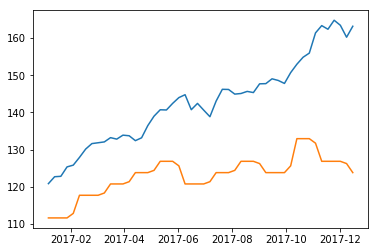

EMRATIO:Basic Materials (IYM)
Accuracy: 8.7
Coefficients [[ 4.42218427]]


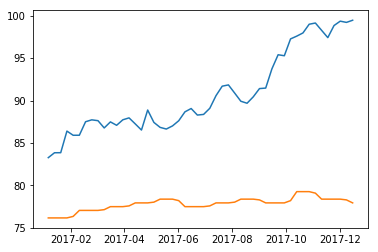

EMRATIO:Consumer Goods (IYK)
Accuracy: 86.21
Coefficients [[ 24.43302657]]


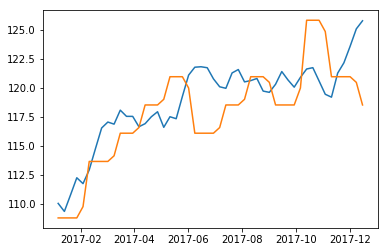

EMRATIO:Services (IYC)
Accuracy: 78.78
Coefficients [[ 37.86006926]]


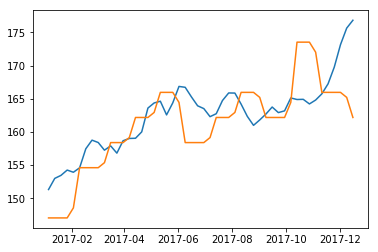

EMRATIO:Utilities (IDU)
Accuracy: 87.1
Coefficients [[ 28.61976415]]


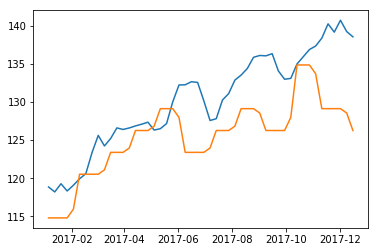

IPMAN:Healthcare (IYH)
Accuracy: 77.75
Coefficients [[ 5.4313629]]


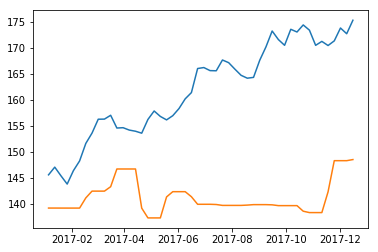

In [566]:
# ======== training the existing data ========

# setting date range
traindate = ['2013','2016-12-29']
testdate = ['2017-01-01','2017-12-15']

# EMRATIO had best correlation
linreg_analysis('EMRATIO','Technology (IYW)',traindate[0],traindate[1],testdate[0],testdate[1], True)
linreg_analysis('EMRATIO','Basic Materials (IYM)',traindate[0],traindate[1],testdate[0],testdate[1],True)
linreg_analysis('EMRATIO','Consumer Goods (IYK)',traindate[0],traindate[1],testdate[0],testdate[1],True)
linreg_analysis('EMRATIO','Services (IYC)',traindate[0],traindate[1],testdate[0],testdate[1],True)
linreg_analysis('EMRATIO','Utilities (IDU)',traindate[0],traindate[1],testdate[0],testdate[1],True)

# IPMAN had better correlation than EMRATIO
linreg_analysis('IPMAN','Healthcare (IYH)',traindate[0],traindate[1],testdate[0],testdate[1],True)

In [567]:
# ======== calculating future indicator value ========

# create indexable column for simple linear regression mapping
sec_indic['date'] = range(1,331)

# calculating future indicator for calculating future ETFs
traindate = ['2010','2016']
testdate = ['2017-12-22','2018-6-29']
EMRATIOlist = linreg_analysis('date','EMRATIO',traindate[0],traindate[1],testdate[0],testdate[1],False)

# save predicted indicator values to sec-Indic slice 
sec_indic['2017-12-22':'2018-6-29']['EMRATIO'] = EMRATIOlist

# NOTE: SYNTAX FOR SLICING DOES NOT APPEAR TO BE CORRECT FOR SAVING LIST (OUTDATED?)

date:EMRATIO


/Users/ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [570]:
# ======== calculating future ETF values with predicted indicator ========

# DATE RANGE: '2017-12-22':'2018-04-06'


# create new predictor dataframe
final_predict = sec_indic.copy()
final_predict = final_predict['2017-12-22':'2018-04-06']

# set new train/test dates
traindate = ['2012-03-09','2017-12-15']
testdate = ['2017-12-22','2018-04-06']

# run final predictions and store values
final_predict['Technology (IYW)'] = linreg_analysis('EMRATIO','Technology (IYW)',traindate[0],traindate[1],testdate[0],testdate[1], False)
final_predict['Basic Materials (IYM)'] = linreg_analysis('EMRATIO','Basic Materials (IYM)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Consumer Goods (IYK)'] = linreg_analysis('EMRATIO','Consumer Goods (IYK)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Services (IYC)'] = linreg_analysis('EMRATIO','Services (IYC)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Utilities (IDU)'] = linreg_analysis('EMRATIO','Utilities (IDU)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Healthcare (IYH)'] = linreg_analysis('EMRATIO','Healthcare (IYH)',traindate[0],traindate[1],testdate[0],testdate[1],False)

# Delete unneccesary columns
del final_predict['date']
for column in features:
    del final_predict[column]
    
final_predict.to_csv('RyanETF-Dec2017Apr2018.csv')

EMRATIO:Technology (IYW)
EMRATIO:Basic Materials (IYM)
EMRATIO:Consumer Goods (IYK)
EMRATIO:Services (IYC)
EMRATIO:Utilities (IDU)
EMRATIO:Healthcare (IYH)


In [571]:
# ======== calculating future ETF values with predicted indicator ========

# DATE RANGE: '2018-04-13':'2018-6-29'

# create new predictor dataframe
final_predict = sec_indic.copy()
final_predict = final_predict['2018-04-13':'2018-6-29']

# set new train/test dates
traindate = ['2012-03-09','2017-12-15']
testdate = ['2018-04-13','2018-6-29']


# run final predictions and story values
final_predict['Technology (IYW)'] = linreg_analysis('EMRATIO','Technology (IYW)',traindate[0],traindate[1],testdate[0],testdate[1], False)
final_predict['Basic Materials (IYM)'] = linreg_analysis('EMRATIO','Basic Materials (IYM)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Consumer Goods (IYK)'] = linreg_analysis('EMRATIO','Consumer Goods (IYK)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Services (IYC)'] = linreg_analysis('EMRATIO','Services (IYC)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Utilities (IDU)'] = linreg_analysis('EMRATIO','Utilities (IDU)',traindate[0],traindate[1],testdate[0],testdate[1],False)
final_predict['Healthcare (IYH)'] = linreg_analysis('EMRATIO','Healthcare (IYH)',traindate[0],traindate[1],testdate[0],testdate[1],False)

# Delete unneccesary columns
del final_predict['date']
for column in features:
    del final_predict[column]
    
final_predict.to_csv('RyanETF-Apr2018Jun2018.csv')

EMRATIO:Technology (IYW)
EMRATIO:Basic Materials (IYM)
EMRATIO:Consumer Goods (IYK)
EMRATIO:Services (IYC)
EMRATIO:Utilities (IDU)
EMRATIO:Healthcare (IYH)
